In [1]:
import io
import os
import boto3
import numpy as np
import pandas as pd
import matplotlib.spines as sp
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
font = {'weight': 'bold'
       ,'size': 16}
plt.rc('font', **font)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, mean_squared_error,r2_score, make_scorer, roc_auc_score, roc_curve, auc, recall_score, plot_confusion_matrix

In [2]:
aws_id = os.environ['AWS_ACCESS_KEY_ID']
aws_secret = os.environ['AWS_SECRET_ACCESS_KEY']
client = boto3.client('s3'
                     ,aws_access_key_id=aws_id
                     ,aws_secret_access_key=aws_secret)

train_obj = client.get_object(Bucket='food-delivery-churn', Key='original_churn_train.csv')
test_obj = client.get_object(Bucket='food-delivery-churn', Key='original_churn_test.csv')

In [3]:
training = pd.read_csv(io.BytesIO(train_obj['Body'].read())
                            ,encoding='utf8'
                            ,parse_dates=['signup_time_utc', 'last_order_time_utc']
                            ,date_parser=pd.to_datetime)

testing = pd.read_csv(io.BytesIO(test_obj['Body'].read())
                            ,encoding='utf8'
                            ,parse_dates=['signup_time_utc', 'last_order_time_utc']
                            ,date_parser=pd.to_datetime)

In [4]:
y_train = training.pop('churned_user').values
y_test = testing.pop('churned_user').values

In [5]:
X_train = training.drop(['user_id', 'signup_time_utc', 'last_order_time_utc'], axis=1)
X_test = testing.drop(['user_id', 'signup_time_utc', 'last_order_time_utc'], axis=1)
X_train.info()
# select_columns = ['signup_to_order_hours'
#                  ,'first_order_discount_percent'
#                  ,'first_30_day_orders'
#                  ,'first_30_day_avg_meal_rating'
#                  ,'first_30_day_avg_driver_rating'
#                  ,'first_30_day_discount_percent']
# churn_train_X_drop.loc[:, churn_train_X_drop.columns.to_series().str.startswith("first_30")]
# churn_train_X_drop.columns.to_series().str.startswith(("first_30", "city", "signup"))
# X_train_catchurn_train_X_drop.select_dtypes(include=['object']).columns.tolist()
X_train.select_dtypes(include=['object']).columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141766 entries, 0 to 141765
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   city_name                       141766 non-null  object 
 1   acquisition_channel             141766 non-null  object 
 2   days_since_signup               141766 non-null  int64  
 3   signup_to_order_hours           141766 non-null  float64
 4   first_order_driver_rating       141766 non-null  int64  
 5   first_order_avg_meal_rating     141766 non-null  float64
 6   first_order_meal_reviews        141766 non-null  int64  
 7   first_order_delivered_on_time   141766 non-null  bool   
 8   first_order_hours_late          141766 non-null  float64
 9   first_order_gmv                 141766 non-null  float64
 10  first_order_discount_percent    141766 non-null  float64
 11  first_order_driver_tips         141766 non-null  float64
 12  first_30_day_ord

['city_name', 'acquisition_channel']

In [6]:
def convert_cat_to_int(data, col):
    '''
    Args:
        data (Pandas DF): A pandas DF with a column 'col' to convert string/boolean values to integers
        col (str) = The name of the column to convert from categorical to integer
        
    Returns:
        data (Pandas DF): A pandas DF with t
    '''
    col_dict = {}
    for idx, cat in enumerate(data[col].unique()):
        col_dict[cat] = idx

    data[col] = data[col].map(lambda x: col_dict[x])

    return data

In [7]:
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()
for col in cat_columns:
    X_train[col] = convert_cat_to_int(X_train, col)
    X_test[col] = convert_cat_to_int(X_test, col)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.fit_transform(X_test, y_test)

In [9]:
gradient_boosting_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.25]
                            ,'max_depth': [2, 4, 8]
                            ,'max_features': ['sqrt', 'log2', None]
                            ,'min_samples_leaf': [1, 2, 4]
                            ,'subsample': [0.25, 0.5, 0.75, 1.0]
                            ,'n_estimators': [5,10,25,50,100,200]}
model = RandomizedSearchCV(GradientBoostingClassifier()
            ,gradient_boosting_grid
            ,n_jobs=-1
            ,verbose=False
            ,scoring='roc_auc')

model.fit(X_train_scaled, y_train)

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.25],
                                        'max_depth': [2, 4, 8],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [5, 10, 25, 50, 100,
                                                         200],
                                        'subsample': [0.25, 0.5, 0.75, 1.0]},
                   scoring='roc_auc', verbose=False)

In [10]:
importances = model.best_estimator_.feature_importances_
std = np.std([tree[0].feature_importances_ for tree in model.best_estimator_.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
indices

array([ 2, 12,  3, 19, 16, 10, 15, 17, 14,  9, 11,  1,  0, 18,  6,  8,  5,
       13,  4,  7])

In [14]:
feature_names = np.array(X_train.columns.tolist())
# for i,j in enumerate(indices):
#     if i < 3:
#         feature = X_train.columns.tolist()[j].replace("_", " ").title()
#         feature_names.append(feature)
#     elif i > len(indices) - 4:
#         feature = X_train.columns.tolist()[j].replace("_", " ").title()
#         feature_names.append(feature)
#     else:
# #         feature_names.append(f"Feature {indices[i]}")
#         feature_names.append(''.join(i*' '))
# feature_names

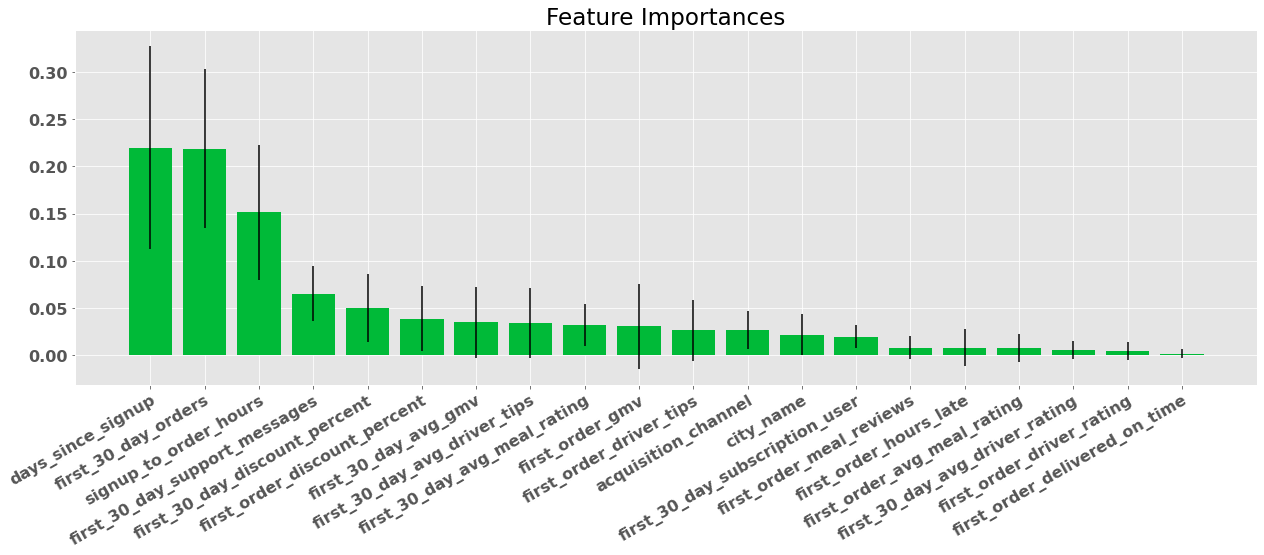

In [15]:
# Plot the impurity-based feature importances of the forest
fig, ax = plt.subplots(figsize=(18,8))

ax.set_title("Feature Importances")
ax.bar(feature_names[indices], importances[indices],
        color="#00BA38", yerr=std[indices], align="center")
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha='right', rotation_mode="anchor");
# ax.xticks(range(X_train.shape[1]), indices)
# ax.xlim([-1, len(top_3_features)]);
# plt.show()
plt.tight_layout()
plt.savefig("../images/feature_importances.png", dpi=400)

In [68]:
sm_model = sm.Logit(y_train, X_train_scaled[:,[2,3,5,10,11,12,14,15,16,18,19]])
answer = sm_model.fit()
answer.summary()
# print(lr_model.best_estimator_)
# print(lr_model.best_estimator_.coef_)
# print(lr_model.best_score_)

Optimization terminated successfully.
         Current function value: 0.649769
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               141766
Model:                          Logit   Df Residuals:                   141755
Method:                           MLE   Df Model:                           10
Date:                Thu, 01 Apr 2021   Pseudo R-squ.:                 -0.2323
Time:                        10:13:11   Log-Likelihood:                -92115.
converged:                       True   LL-Null:                       -74753.
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3013      0.006     49.195      0.000       0.289       0.313
x2            -0.3204      0.006    -51.962      0.000      -0.333      -0.308
x3             0.0844      0.010      8.539      0.000       0.065       0.104
x4            -0.0888      0.016     -5.663      0.000      -0.120      -0.058
x5            -0.0661      0.008     -7.860      0.000      -0.083      -0.050
x6            -0.5644      0.010    -58.703      0.000      -0.583      -0.546
x7            -0.1754      0.010    -17.096      0.000      -0.196      -0.155
x8             0.0380      0.008      4.467      0.000       0.021       0.055
x9             0.2552      0.016     16.173      0.000       0.224       0.286
x10           -0.0765      0.006    -12.263      0.000      -0.089      -0.064
x11            0.0353      0.012      2.990      0.003       0.012       0.058
==============================================================================
"""

In [46]:
for idx, col in enumerate(X_train.columns.tolist()):
    print(f"{idx+1}: {col}")

1: city_name
2: acquisition_channel
3: days_since_signup
4: signup_to_order_hours
5: first_order_driver_rating
6: first_order_avg_meal_rating
7: first_order_meal_reviews
8: first_order_delivered_on_time
9: first_order_hours_late
10: first_order_gmv
11: first_order_discount_percent
12: first_order_driver_tips
13: first_30_day_orders
14: first_30_day_avg_driver_rating
15: first_30_day_avg_meal_rating
16: first_30_day_avg_gmv
17: first_30_day_discount_percent
18: first_30_day_avg_driver_tips
19: first_30_day_subscription_user
20: first_30_day_support_messages


In [31]:
y_hats = lr_model.predict(X_test)

In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hats).ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
print(\
f"---------------------------------\n"\
f"          |        True         |\n"\
f"Predicted |  {tp}   |    {fp}  |\n"\
f"          |  {fn}    |    {tn}  |\n"\
f"---------------------------------")

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"AUC: {roc_auc_score(y_test, y_hats):.4f}")

---------------------------------
          |        True         |
Predicted |  19147   |    3521  |
          |  7147    |    4468  |
---------------------------------
Accuracy: 0.6888
Recall: 0.7282
Precision: 0.8447
AUC: 0.6437


In [33]:
# mean_squared_error
# r2_score
# make_scorer
roc_curve(y_test, y_hats)
# auc
# recall_score

(array([0.        , 0.44073101, 1.        ]),
 array([0.        , 0.72818894, 1.        ]),
 array([2, 1, 0]))

In [34]:
def plot_model_aoc(classifier, X_test, y_test, ax, plot_kwargs={}):
    """ Plots the AOC Curve for a classifier given the test data and axis
    Args:
        classifier (Sklearn Classifier): The best classifier to test against other classifiers
        X_test (numpy array): Values to use when predicting with the classifier
        y_test (numpy array): True target values to evaluate the predictors against
        ax (matplotlib axis): An axis to plot the AOC curve on.

    Returns: 
        None
        Modifies ax by plotting the AOC curve from the best classifier.
    """
    y_preds = classifier.predict_proba(X_test)[:,1] 
    auc_score = roc_auc_score(y_test, y_preds)
    fpr, tpr, threshold = roc_curve(y_test, y_preds)
    roc_df = pd.DataFrame(zip(fpr, tpr, threshold), columns = ['fpr', 'tpr', 'threshold'])
    ax.plot(roc_df.fpr, roc_df.tpr, label=f"{classifier.__class__.__name__} AUC={auc_score:.3f}", **plot_kwargs)

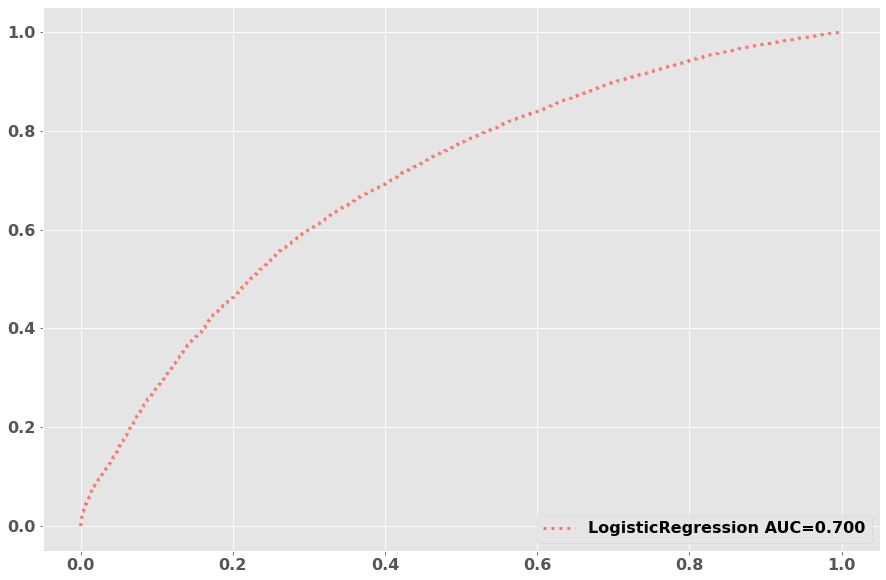

In [46]:
fig, ax = plt.subplots(figsize=(15,10))

plot_model_aoc(lr_model, X_test, y_test, ax, plot_kwargs={'linestyle':':'
                                                          ,'linewidth': 3
                                                          ,'color': '#F8766D'})
ax.legend(loc='lower right')